<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Predicting-Car-Speed-from-Dashcam-Video" data-toc-modified-id="Predicting-Car-Speed-from-Dashcam-Video-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Predicting Car Speed from Dashcam Video</a></span><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Imports</a></span><ul class="toc-item"><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Preprocessing</a></span></li><li><span><a href="#Construct-Dataset" data-toc-modified-id="Construct-Dataset-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Construct Dataset</a></span></li><li><span><a href="#Cropping" data-toc-modified-id="Cropping-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Cropping</a></span></li><li><span><a href="#Testing-Optical-Flow" data-toc-modified-id="Testing-Optical-Flow-1.1.4"><span class="toc-item-num">1.1.4&nbsp;&nbsp;</span>Testing Optical Flow</a></span></li><li><span><a href="#Data--&gt;-Train-/-Validation-/-Evaluation" data-toc-modified-id="Data-->-Train-/-Validation-/-Evaluation-1.1.5"><span class="toc-item-num">1.1.5&nbsp;&nbsp;</span>Data -&gt; Train / Validation / Evaluation</a></span></li><li><span><a href="#Build-Optical-Flow-Dataset" data-toc-modified-id="Build-Optical-Flow-Dataset-1.1.6"><span class="toc-item-num">1.1.6&nbsp;&nbsp;</span>Build Optical Flow Dataset</a></span></li><li><span><a href="#Build-Data-Generators" data-toc-modified-id="Build-Data-Generators-1.1.7"><span class="toc-item-num">1.1.7&nbsp;&nbsp;</span>Build Data Generators</a></span></li></ul></li><li><span><a href="#Model-Training" data-toc-modified-id="Model-Training-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Model Training</a></span><ul class="toc-item"><li><span><a href="#2D-CNN" data-toc-modified-id="2D-CNN-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>2D CNN</a></span></li><li><span><a href="#2D-CNN-+-LSTM" data-toc-modified-id="2D-CNN-+-LSTM-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>2D CNN + LSTM</a></span></li></ul></li><li><span><a href="#Model-Evaluation" data-toc-modified-id="Model-Evaluation-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Model Evaluation</a></span></li></ul></li><li><span><a href="#Additional-Considerations" data-toc-modified-id="Additional-Considerations-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Additional Considerations</a></span></li></ul></div>

# Predicting Car Speed from Dashcam Video

My approach will be to calculate optical flow between pairs of successive frames and use that as a metric to predict the car speed via a CNN. 

A general outline of what we'll be doing:

1. Split up given data into training & test
2. Preprocess frames
    * Augment training frames with regularized illumination factor
    * Crop noise out of the frame (car dashboard, etc.) 
    * Interpolate image to input size of neural network
3. Train, validate, hyperparameterize CNN



## Imports

In [426]:
import cv2
import skvideo.io
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
import os
from tqdm import tqdm_notebook
import cv2
from matplotlib import pyplot as plt
import numpy as np
import shutil
from imgaug import augmenters as iaa

VIDEO_FP = "data/train.mp4"
TEST_VIDEO_FP = "data/test.mp4"
SPEEDS_FP = "data/train.txt"
NUM_FRAMES = 20400
TEST_NUM_FRAMES = 10798

# Folder names
MAIN = "main"
OPTICAL = "optical"

### Preprocessing

### Construct Dataset

Let's split the video into frames & save them as images in a seperate folder. 

This way we don't need to have the entire video in memory.

In [12]:
def create_empty_folder(target_folder):
    if os.path.exists(target_folder):
        shutil.rmtree(target_folder)

    os.mkdir(target_folder)


def get_image_path(folder, num_frame):
    return os.path.join(folder, str(num_frame) + '.jpg')


def load_image(image_path):
    assert os.path.isfile(image_path)
    bgr_img = cv2.imread(image_path)
    rbg_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
    return rbg_img


def construct_dataset(video_fp, target_folder, num_frames):

    create_empty_folder(target_folder)

    cap = cv2.VideoCapture(video_fp)

    frame_num = 0
    pbar = tqdm_notebook(total=num_frames)
    while(cap.isOpened()):
        _, frame = cap.read()
        if frame_num > num_frames:
            break
        img_path = get_image_path(target_folder, frame_num)
        cv2.imwrite(img_path, frame)
        pbar.update(1)
        frame_num += 1
    cap.release()
    pbar.close()

In [39]:
construct_dataset(VIDEO_FP, MAIN, NUM_FRAMES)

Let's also read in the speed data.

Since we atleast need two frames to determine speed, we won't consider the speed of the first frame a valid training point since it has no prior frame. As such, we'll drop it from the dataframe. We will use the average speed between two successive frames as the output.

In [144]:
def speeds_to_df(speeds_fp, num_frames, avg_speed=True):
    speeds_df = pd.read_csv(speeds_fp, header=None, nrows=num_frames)
    speeds_df.columns = ['speed']

    if avg_speed:
        speeds_df['speed'] = speeds_df['speed'].rolling(2).mean()
        
    return speeds_df

def crop_df(speeds_df, window_size):
    # Crop the head of the dataframe when window_size > 1
    return speeds_df.drop(speeds_df.index[:window_size])

speeds_df = speeds_to_df(SPEEDS_FP, NUM_FRAMES)
speeds_df = crop_df(speeds_df, 1)
speeds_df.head()

speed
1  28.105569
2  28.106048
3  28.118465
4  28.119823
5  28.098907

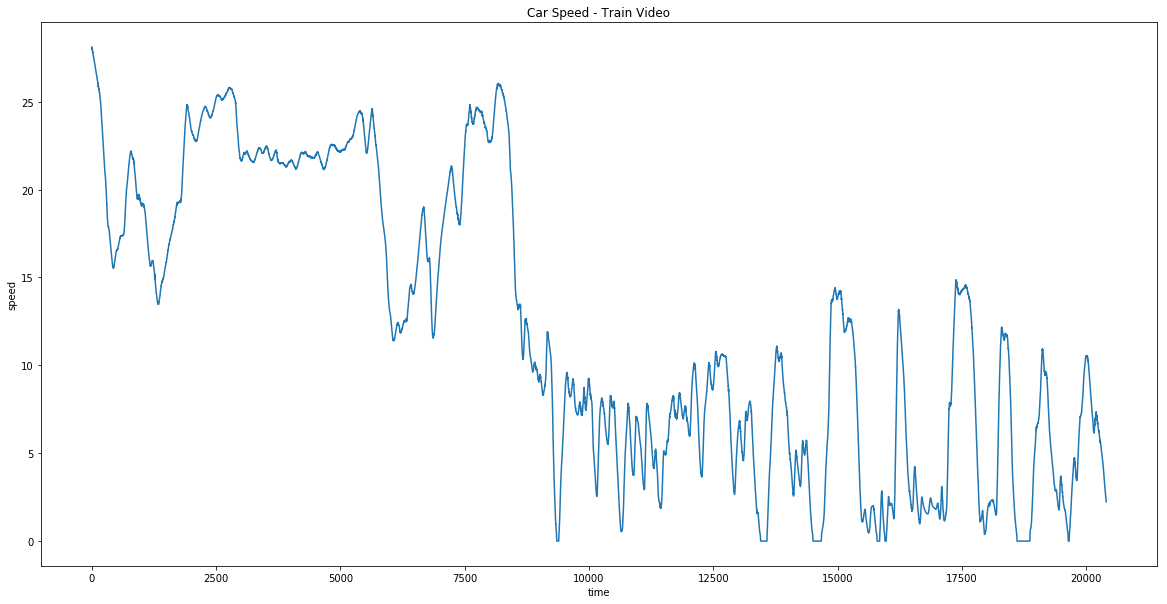

In [278]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.plot(speeds_df)
plt.xlabel('time')
plt.ylabel('speed')
plt.title('Car Speed - Train Video')
plt.show()

### Cropping

Let's take a look at what we can remove from the image (sky, dashboard, etc.)

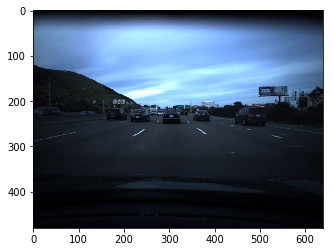

In [544]:
def custom_crop(image):
    cropped_image = image[150:350, 100:-100]
    return cropped_image

def bottom_crop(image, top_crop, side_crop):
    cropped_image = image[top_crop:, side_crop:-side_crop]
    return cropped_image

crop_dummy = load_image(get_image_path(MAIN, 400))
plt.imshow(crop_dummy)
plt.show()

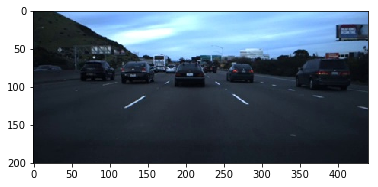

In [530]:
plt.imshow(custom_crop(crop_dummy))
plt.show()

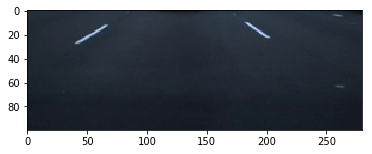

In [547]:
plt.imshow(bottom_crop(custom_crop(crop_dummy), 100, 80))
plt.show()

### Testing Optical Flow

I want to try calculating optical flow via the Farneback method that calculates dense optical flow. This means we have flow vectors for all pixels.

In [531]:
def cartesian_farneback_optical_flow(image_current, image_next):
    gray_current = cv2.cvtColor(image_current, cv2.COLOR_RGB2GRAY)
    gray_next = cv2.cvtColor(image_next, cv2.COLOR_RGB2GRAY)

    # Flow Parameters
    flow_mat = None
    image_scale = 0.5
    nb_images = 1
    win_size = 15
    nb_iterations = 2
    deg_expansion = 5
    STD = 1.3
    extra = 0

    # obtain dense optical flow paramters
    flow = cv2.calcOpticalFlowFarneback(gray_current, gray_next,
                                        flow_mat,
                                        image_scale,
                                        nb_images,
                                        win_size,
                                        nb_iterations,
                                        deg_expansion,
                                        STD,
                                        0)

    return flow


def rgb_farneback_optical_flow(image_current, image_next):
    hsv = np.zeros(image_next.shape, dtype=np.uint8)

    # set saturation
    hsv[:, :, 1] = cv2.cvtColor(image_next, cv2.COLOR_RGB2HSV)[:, :, 1]

    # obtain dense optical flow paramters
    flow = cartesian_farneback_optical_flow(image_current, image_next)

    # convert from cartesian to polar
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])

    # hue corresponds to direction
    hsv[..., 0] = ang * (180 / np.pi / 2)

    # value corresponds to magnitude
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)

    # convert HSV to int32's
    #hsv = np.asarray(hsv, dtype= np.float32)
    rgb_flow = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    return rgb_flow

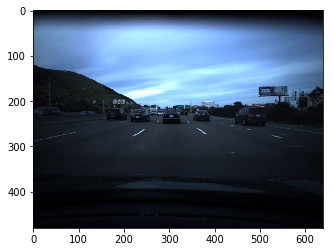

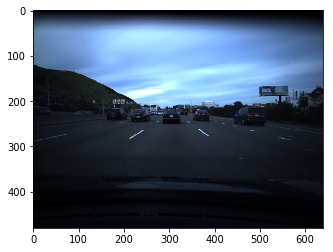

In [70]:
A = load_image(get_image_path(MAIN, 400))
B = load_image(get_image_path(MAIN, 401))
plt.imshow(A)
plt.show()
plt.imshow(B)
plt.show()

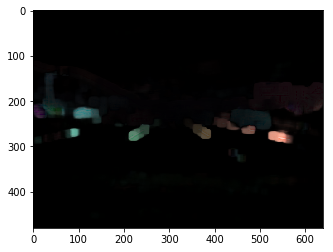

In [29]:
D = rgb_farneback_optical_flow(A, B)
plt.imshow(D)
plt.show()

The farneback method is much faster. On top of that, it looks like it's better at picking up flow vectors from static markers. These flow vectors are more important than those from noise like cars, etc. as there are more variables affecting the flow vectors of other moving objects than static markers. In fact, if we wanted to do better, we should find a way of identifying flow vectors from static objects & give more weight to those. 

We should also take some more knowledge of the real world and apply as that as a heuristic to filter noise. For instance, if the camera moves in space towards any point in the field of view then the flow vectors from static objects should all intersect at that point. 

A visual example:

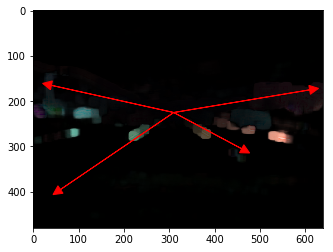

In [30]:
plt.imshow(D)
plt.arrow(310, 225, -270, -60, color="red", head_width=20, head_length=20)
plt.arrow(310, 225, 150, 80, color="red", head_width=20, head_length=20)
plt.arrow(310, 225, -250, 170, color="red", head_width=20, head_length=20)
plt.arrow(310, 225, 300, -50, color="red", head_width=20, head_length=20)
plt.show()

We would expect this kind of analysis to remove the vectors from the cars in the image. However, we don't always have this intersection in our field of view. Sometimes the car can be turning fast & the camera moves towards a point it does not have in its FOV. So, we would apply this heuristic with the appropriate precautions.

Before going deep into this, I'd like to have a baseline model & then apply this kind of analysis if it performs poorly. Let's start by creating our test & train data. 

### Data -> Train / Validation / Evaluation

From the data for which we know the speeds, we will split it into training, validation, and evaluation data.

We will train the model on training, cross validate & tune with validation, and then finally evaluate performance on the evaluation set. 

We can randomly shuffle the available training frames into these three sets, but I don't think that's good enough. It's quite likely that most of the evaluation and validation sets will not be contigious. This means the model will have already seen small bits and pieces of very similar environments. I want to set aside about 30% of the validation & evaluation sets as continious frames. 

In [145]:
def split_dataset(df, split):
    continuous_train_df, continuous_test_df = train_test_split(
        df, test_size=0.05, shuffle=False, random_state=46)
    train_df, shuffle_test_df = train_test_split(
        continuous_train_df, test_size=split, random_state=46)

    test_df = pd.concat([shuffle_test_df, continuous_test_df])

    return train_df, test_df


train_df, evaluation_df = split_dataset(speeds_df, 0.07) 
train_df, validation_df = split_dataset(train_df, 0.15)

# Sanity Check; this should give us the number of training points available
num_data_points = train_df.shape[0] + evaluation_df.shape[0] + validation_df.shape[0]
print(num_data_points)
print(validation_df.shape[0] / num_data_points)
print(evaluation_df.shape[0] / num_data_points)

20399
0.17010637776361587
0.11652531986862101


### Build Optical Flow Dataset
Now, we can process pairs of successive frames to build the train, validation, and evaluation sets. 
We will crop the frames, calculate optical flow, and resize the result to the input size of our neural network. 
The one difference that sets apart the train set is that pairs of images should be augmented by an illumination factor to regularize against brightness changes.

In [657]:
def custom_resize(image, img_height, img_width):
    resized_image = cv2.resize(
        image, (img_width, img_height), interpolation=cv2.INTER_AREA)
    return resized_image


def change_brightness(image, bright_factor):
    """
    Augments the brightness of the image
    Input: image (RGB)
    returns: image with brightness augmentation
    """

    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    # perform brightness augmentation only on the second channel
    hsv_image[:, :, 2] = hsv_image[:, :, 2] * bright_factor

    # change back to RGB
    image_rgb = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)
    return image_rgb

def construct_optical_flow_dataset(frames_df, dataset_folder, target_folder, augment_brightness_indices=[]):

    create_empty_folder(target_folder)

    for idx, row in tqdm_notebook(frames_df.iterrows(), total=len(frames_df)):
        curr_img_path = get_image_path(dataset_folder, idx)
        preceding_img_path = get_image_path(dataset_folder, idx - 1)

        curr_img = load_image(curr_img_path)
        preceding_img = load_image(preceding_img_path)
        
        curr_img = custom_crop(curr_img)
        preceding_img = custom_crop(preceding_img)

        if idx in augment_brightness_indices:
            bright_factor = np.random.uniform(0, 1.3)
            curr_img = change_brightness(curr_img, bright_factor)
            preceding_img = change_brightness(preceding_img, bright_factor)

        flow = cartesian_farneback_optical_flow(preceding_img, curr_img)

        curr_flow_path = os.path.join(target_folder, str(idx) + '.npy')
        np.save(curr_flow_path, flow)

In [658]:
construct_optical_flow_dataset(speeds_df, MAIN, OPTICAL, 
                               train_df.index.values.tolist())

HBox(children=(IntProgress(value=0, max=20399), HTML(value='')))

It's much faster to precompute the flow values and then use the generator below to feed training & validation samples to the neural net. The reason for this is because the network will reuse the same images many times, resulting in unneccessary recomputation of flow values. It's best to precompute all these, rather than have them in memory or generate them on the fly each time. 

### Build Data Generators

In [738]:
def augment_images(images):
    """ 
    Augment a batch of images with transforms
    """
    
    def sometime(aug): return iaa.Sometimes(0.3, aug)
    
    sequence = iaa.Sequential(
        [
            sometime(iaa.Dropout((0.0, 0.1))),
            sometime(iaa.CoarseDropout((0.0, 0.1),size_percent=(0.01, 0.02), per_channel=0.2)),
        ]
        , random_order=True)

    flip = np.random.random() > 0.5

    if flip:
        images = [cv2.flip(img, 1) for img in images]

    bright_factor = np.random.uniform(0, 1.3)
    images = [change_brightness(img, bright_factor) for img in images]
    images = sequence.augment_images(images)
    return images


def generate_img_samples(dataset_folder, df, img_height, img_width, window=1, batch_size=16,
                         augment=False):

    if window > 1:
        input_batch = np.zeros(
            (batch_size, window, img_height, img_width, 3), dtype=np.uint8)
    else:
        input_batch = np.zeros(
            (batch_size, img_height, img_width, 3), dtype=np.uint8)

    output_batch = np.zeros((batch_size, 1))

    while True:
        for i in range(batch_size):
            data_idx = np.random.randint(0, len(df) - 1)
            row = df.iloc[data_idx]
            output_batch[i] = row['speed']
            img_index = int(row.name)

            for j in range(window):
                img_path = get_image_path(
                    dataset_folder, img_index - window + j + 1)
                img = load_image(img_path)
                if img.shape != (img_height, img_width):
                    img = custom_crop(img)
                    img = custom_resize(img, img_height, img_width)
                if window > 1:
                    input_batch[i, j] = img
                else:
                    input_batch[i] = img

        yield (input_batch, output_batch)


def generate_flow_samples(dataset_folder, df, img_height, img_width, img_channels,
                          batch_size=16, augment=False):

    input_batch = np.zeros((batch_size, img_height, img_width, img_channels))
    output_batch = np.zeros((batch_size, 1))

    while True:
        for i in range(batch_size):
            data_idx = np.random.randint(0, len(df) - 1)
            row = df.iloc[data_idx]
            output_batch[i] = row['speed']
            flow_index = int(row.name)
        
            flow_path = os.path.join(dataset_folder, str(flow_index) + '.npy')
            flow_img = np.load(flow_path)

            #flow_img = bottom_crop(flow_img, 60, 50)

            flow_img = custom_resize(flow_img, img_height, img_width)

            mag, ang = cv2.cartToPolar(flow_img[..., 0], flow_img[..., 1])
            mag_ang_img = np.stack([mag, ang], axis=2)
            
            input_batch[i] = mag_ang_img
            
            if augment:
                input_batch = augment_images(input_batch)

        yield (input_batch, output_batch)


def generate_img_flow_samples(dataset_folder, df, img_height, img_width, img_channels, window=1,
                              batch_size=16, augment=False):
    if window > 1:
        input_batch = np.zeros(
            (batch_size, window, img_height, img_width, img_channels), dtype=np.uint8)
    else:
        input_batch = np.zeros(
            (batch_size, img_height, img_width, img_channels), dtype=np.uint8)

    output_batch = np.zeros((batch_size, 1))
    flow_img_batch = np.zeros(
        (batch_size, img_height, img_width, img_channels))

    while True:
        for i in range(batch_size):
            data_idx = np.random.randint(0, len(df) - 1)
            row = df.iloc[data_idx]
            output_batch[i] = row['speed']
            img_index = int(row.name)

            flow_path = os.path.join(OPTICAL, str(img_index) + '.npy')
            flow_img = np.load(flow_path)
            if flow_img.shape != (N_img_height, N_img_width):
                flow_img = custom_resize(flow_img)
            flow_img_batch[i] = flow_img

            for j in range(window):
                img_path = get_image_path(
                    dataset_folder, img_index - window + j + 1)
                img = load_image(img_path)
                if img.shape != (N_img_height, N_img_width):
                    img = custom_resize(img)

                if window > 1:

                    input_batch[i, j] = img
                else:
                    input_batch[i] = img

        yield ([input_batch, flow_img_batch], output_batch)

Let's test our generators.

In [743]:
train_generator = generate_flow_samples(OPTICAL, train_df, 100, 220, 2, batch_size=16, augment=False)
input_x, output_y = next(train_generator)
print(sum(input_x[0].flatten())/(100 * 300))
# plt.imshow(input_x[0])
# plt.show()

3.0539148266316714


## Model Training

Approach:
* Build a simple model: Input-> Convolution layers -> Flatten -> Dense layers -> 1 value
* Improve test MSE by adding layers, until it no longer improves
* Then prevent overfitting by adding dropout layers
* Test on eval set

Other things I tried:
* Test between ELU vs RELU (RELU wins for this task)
* Try to use more than 1 successive optical flow frame, this is the WINDOW_SIZE variable

### 2D CNN

In [744]:
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, Convolution3D, ZeroPadding3D
from keras.layers.pooling import MaxPooling2D, MaxPooling3D
from keras.layers.core import Activation, Dropout, Flatten, Dense, Lambda
from keras.layers import ELU, TimeDistributed, LSTM, Input, Reshape, Concatenate
from keras.optimizers import Adam, SGD
import keras.backend.tensorflow_backend as KTF
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications import ResNet50
from keras.layers.normalization import BatchNormalization
from keras.models import Model

# Reset model backend
KTF.clear_session() 

def cnn_2d(img_height, img_width, img_channels = 3):
    
    inputShape = (img_height, img_width, img_channels)
    
    model = Sequential()

    model.add(Lambda(lambda x: x / 127.5 - 1, input_shape=inputShape, name="normalize"))

    model.add(Convolution2D(24, (5, 5),
                            strides=(2, 2),
                            padding='valid',
                            kernel_initializer='he_normal',
                            name='conv1'))
    model.add(ELU()) 
    
    model.add(Convolution2D(36, (5, 5),
                            strides=(2, 2),
                            padding='valid',
                            kernel_initializer='he_normal',
                            name='conv2'))
    model.add(ELU()) 
    
    model.add(Convolution2D(48, (5, 5),
                            strides=(2, 2),
                            padding='valid',
                            kernel_initializer='he_normal',
                            name='conv3'))
    model.add(ELU()) 

    model.add(Dropout(0.2, name="dropout"))
    
    model.add(Convolution2D(64, (3, 3),
                            strides=(1, 1),
                            padding='valid',
                            activation='relu',
                            kernel_initializer='he_normal',
                            name='conv4'))
    model.add(ELU()) 
    model.add(Convolution2D(64, (3, 3),
                            strides=(1, 1),
                            padding='valid',
                            kernel_initializer='he_normal',
                            name='conv5'))

    model.add(Flatten(name='flatten'))
    model.add(ELU()) 
    model.add(Dense(100, kernel_initializer='he_normal', name='fc1'))
    model.add(ELU()) 
    model.add(Dense(50, kernel_initializer='he_normal',name='fc2'))
    model.add(ELU()) 
    model.add(Dense(10, kernel_initializer='he_normal', name='fc3'))
    model.add(ELU()) 
    
    model.add(Dense(1, name='output', kernel_initializer='he_normal'))

    return model


def load_model(weights_fp, model_fn):
    model = model_fn()
    model.load_weights(weights_fp)
    return model


WEIGHTS_2DCNN_FP = 'model-weights-2dcnn.h5'

earlyStopping = EarlyStopping(monitor='val_loss',
                              patience=2,
                              verbose=1,
                              min_delta=0.23,
                              mode='min',)

modelCheckpoint = ModelCheckpoint(WEIGHTS_2DCNN_FP,
                                  monitor='val_loss',
                                  save_best_only=True,
                                  mode='min',
                                  verbose=1,
                                  save_weights_only=True)

callbacks_list = [modelCheckpoint, earlyStopping]

IMG_HEIGHT = 100
IMG_WIDTH = 220
IMG_CHANNELS = 2

model = cnn_2d(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalize (Lambda)           (None, 100, 220, 2)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 48, 108, 24)       1224      
_________________________________________________________________
elu_1 (ELU)                  (None, 48, 108, 24)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 22, 52, 36)        21636     
_________________________________________________________________
elu_2 (ELU)                  (None, 22, 52, 36)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 9, 24, 48)         43248     
_________________________________________________________________
elu_3 (ELU)                  (None, 9, 24, 48)         0         
__________

In [ ]:
train_generator = generate_flow_samples(OPTICAL, train_df, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, batch_size=16, augment=False)
validation_generator = generate_flow_samples(OPTICAL, validation_df, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, batch_size=1, augment=False)
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

#sgd = SGD(lr=1e-5, decay=0.0005, momentum=0.9)
model.compile(optimizer=adam, loss='mse')

history = model.fit_generator(
    train_generator,
    steps_per_epoch=400,
    epochs=25,
    callbacks=callbacks_list,
    verbose=1,
    validation_data=validation_generator,
    validation_steps=len(validation_df) - 1)

Epoch 1/25
156/400 [==========>...................] - ETA: 31s - loss: 70.0534

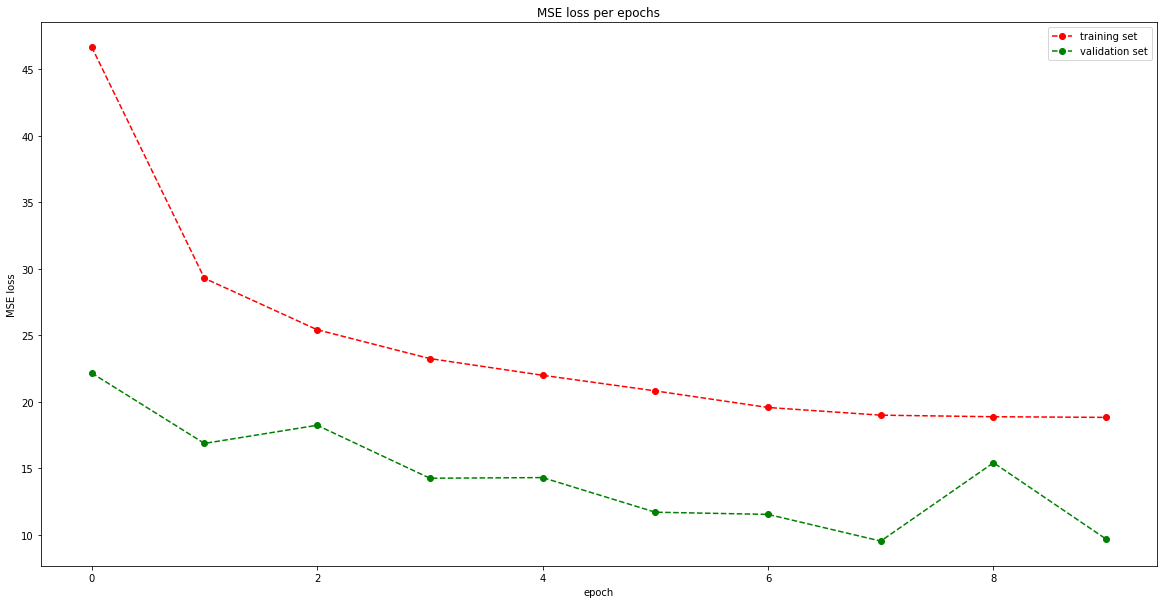

In [27]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.plot(history.history['loss'], 'ro--')
plt.plot(history.history['val_loss'], 'go--')
plt.title('MSE loss per epochs')
plt.ylabel('MSE loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()
plt.close()

### 2D CNN + LSTM

In [ ]:

def cnn_2d_lstm(img_height = 120, img_width = 400, img_channels = 3, window=16):
    
#     model = Sequential()
#     model.add(InputLayer(input_shape=input_shape))
#     model.add(TimeDistributed(base_model, input_shape=input_shape))
#     model.add(LSTM(12))
#     model.add(Dense(100, activation='relu', kernel_initializer='he_normal'))
#     model.add(Dropout(0.5))
#     model.add(Dense(50, activation='relu', kernel_initializer='he_normal'))
#     model.add(Dropout(0.5))
#     model.add(Dense(1))

Let's try to do better. 

I want to use a network that can learn spatial temporal features to predict speed.

I thought wrapping a 2D CNN with an LSTM could show results. The best MSE was around 20.

Then, I saw this paper: https://arxiv.org/pdf/1412.0767.pdf

Let's try to import the model they used. 

The weights are available here: https://drive.google.com/file/d/0BzmDUR5_3US0V1hjV3VvREJ3NGs/view



In [80]:
import h5py


def pop_layer(model):
    if not model.outputs:
        raise Exception('Sequential model cannot be popped: model is empty.')

    model.layers.pop()
    if not model.layers:
        model.outputs = []
        model.inbound_nodes = []
        model.outbound_nodes = []
    else:
        model.layers[-1].outbound_nodes = []
        model.outputs = [model.layers[-1].output]
    model.built = False


def cnn_3d():
    inputShape = (2, N_img_height, N_img_width, N_img_channels)

    model = Sequential()

    model.add(Lambda(lambda x: x / 127.5 - 1, input_shape=inputShape))

    model.add(Convolution3D(24, (3, 3, 3),
                            padding='valid',
                            activation='relu',
                            kernel_initializer='he_normal',
                            name='conv1'))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(
        1, 2, 2), padding='valid', name='pool1'))

    model.add(Convolution3D(36, (3, 3, 3),
                            padding='valid',
                            activation='relu',
                            kernel_initializer='he_normal',
                            name='conv2'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(
        2, 2, 2), padding='valid', name='pool2'))

    model.add(Convolution3D(48, (3, 3, 3),
                            padding='valid',
                            activation='relu',
                            kernel_initializer='he_normal',
                            name='conv3'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(
        2, 2, 2), padding='valid', name='pool3'))

#     model.add(Dropout(0.3))
#     model.add(Convolution3D(64, (3, 3, 3),
#                             padding = 'valid',
#                             activation = 'relu',
#                             kernel_initializer = 'he_normal',
#                             name = 'conv4'))

#     model.add(Convolution3D(64, (3, 3, 3),
#                             padding = 'valid',
#                             activation = 'relu',
#                             kernel_initializer = 'he_normal',
#                             name = 'conv5'))

#     model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='valid', name='pool4'))

    model.add(Flatten(name='flatten'))
    model.add(Dense(100, kernel_initializer='he_normal',
                    activation='relu', name='fc1'))
    model.add(Dense(50, kernel_initializer='he_normal',
                    activation='relu', name='fc2'))
    model.add(Dense(10, kernel_initializer='he_normal',
                    activation='relu', name='fc3'))

    model.add(Dense(1, activation="relu", name='output',
                    kernel_initializer='he_normal'))

    return model


def cnn_3d_sports1m():
    input_shape = (WINDOW, 112, 112, N_img_channels)

    model = Sequential()
    # 1st layer group
    model.add(Convolution3D(64, (3, 3, 3),  activation='relu',
                            padding='same', name='conv1', input_shape=input_shape))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(
        1, 2, 2), padding='valid', name='pool1'))

    # 2nd layer group
    model.add(Convolution3D(128, (3, 3, 3), activation='relu',
                            padding='same', name='conv2'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(
        2, 2, 2), padding='valid', name='pool2'))

    # 3rd layer group
    model.add(Convolution3D(256, (3, 3, 3), activation='relu',
                            padding='same', name='conv3a'))
    model.add(Convolution3D(256, (3, 3, 3), activation='relu',
                            padding='same', name='conv3b'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(
        2, 2, 2), padding='valid', name='pool3'))

    # 4th layer group
    model.add(Convolution3D(512, (3, 3, 3), activation='relu',
                            padding='same', name='conv4a'))
    model.add(Convolution3D(512, (3, 3, 3), activation='relu',
                            padding='same', name='conv4b'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(
        2, 2, 2), padding='valid', name='pool4'))

    # 5th layer group
    model.add(Convolution3D(512, (3, 3, 3), activation='relu',
                            padding='same', name='conv5a'))
    model.add(Convolution3D(512, (3, 3, 3), activation='relu',
                            padding='same', name='conv5b'))
    model.add(ZeroPadding3D(padding=((0, 0), (0, 1), (0, 1)), name='zeropad5'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(
        2, 2, 2), padding='valid', name='pool5'))
    model.add(Flatten())

    # FC layers group
    model.add(Dense(4096, activation='relu', name='fc6'))
    model.add(Dropout(.5))
    model.add(Dense(4096, activation='relu', name='fc7'))
    model.add(Dropout(.5))
    model.add(Dense(1, activation='linear', name='fc8'))

    return model


def resnet_model(n_classes=1000, freeze_layers_from='base_model'):
    input_shape = (224, 224, 3)

    base_model = ResNet50(weights='imagenet', include_top=False,
                          input_shape=input_shape, pooling='avg')

    for layer in base_model.layers:
        layer.trainable = False

    model = base_model
    # Freeze some layers
    if freeze_layers_from is not None:
        if freeze_layers_from == 'base_model':
            print('   Freezing base model layers')
            for layer in base_model.layers:
                layer.trainable = False
        else:
            for i, layer in enumerate(model.layers):
                print(i, layer.name)
            print('   Freezing from layer 0 to ' + str(freeze_layers_from))
            for layer in model.layers[:freeze_layers_from]:
                layer.trainable = False
            for layer in model.layers[freeze_layers_from:]:
                layer.trainable = True

#     model.layers.pop()
#     model.layers[-1].outbound_nodes = []
#     model.outputs = [model.layers[-1].output]
#     output = model.output
#     output = Flatten()(output)
#     output = Dense(output_dim=n_classes, activation='relu')(output) # your newlayer Dense(...)
#     new_model = Model(model.input, output)

    # Add final layers
    # pop_layer(base_model)
    #x = base_model.output
    # print(x.get_shape())
    #x = Flatten()(x)
    #predictions = Dense(n_classes, activation='softmax', name='fc1000')(x)

    # This is the model we will train
    #model = Model(input=base_model.input, output=predictions)

    return model


def cnn_model():
    inputShape = (N_img_height, N_img_width, N_img_channels)

    model = Sequential()

    model.add(Lambda(lambda x: x / 127.5 - 1, input_shape=inputShape))

    model.add(BatchNormalization())
    model.add(Convolution2D(24, (5, 5),
                            strides=(2, 2),
                            padding='valid',
                            activation='relu',
                            kernel_initializer='he_normal',
                            name='conv1'))

    model.add(BatchNormalization())
    model.add(Convolution2D(36, (5, 5),
                            strides=(2, 2),
                            padding='valid',
                            activation='relu',
                            kernel_initializer='he_normal',
                            name='conv2'))

    model.add(BatchNormalization())
    model.add(Convolution2D(48, (5, 5),
                            strides=(2, 2),
                            padding='valid',
                            activation='relu',
                            kernel_initializer='he_normal',
                            name='conv3'))

    model.add(BatchNormalization())
    # model.add(Dropout(0.3))
    model.add(Convolution2D(64, (3, 3),
                            strides=(1, 1),
                            padding='valid',
                            activation='relu',
                            kernel_initializer='he_normal',
                            name='conv4'))

    model.add(BatchNormalization())
    model.add(Convolution2D(64, (3, 3),
                            strides=(1, 1),
                            padding='valid',
                            activation='relu',
                            kernel_initializer='he_normal',
                            name='conv5'))

    model.add(Flatten(name='flattener'))
    return model


def graph_model():
    img_input_shape = (N_img_height, N_img_width, N_img_channels)
    series_input_shape = (WINDOW, N_img_height, N_img_width, N_img_channels)

    resnet = resnet_model()

    resnet_input = Input(shape=img_input_shape)
    resnet_output = resnet(resnet_input)

    flow_input = Input(shape=img_input_shape)
    cnn = cnn_model()
    cnn_output = cnn(flow_input)

    decoder_input = Concatenate()([resnet_output, cnn_output])

    dense1 = Dense(100, kernel_initializer='he_normal',
                   activation='relu', name='fc1')(decoder_input)
    dense2 = Dense(50, kernel_initializer='he_normal',
                   activation='relu', name='fc2')(dense1)
    dense3 = Dense(10, kernel_initializer='he_normal',
                   activation='relu', name='fc3')(dense2)

    output = Dense(1, activation="relu", name='output',
                   kernel_initializer='he_normal')(dense3)
    model = Model(inputs=[resnet_input, flow_input], outputs=output)

#     model = Sequential()
#     model.add(InputLayer(input_shape=input_shape))
#     model.add(TimeDistributed(base_model, input_shape=input_shape))
#     model.add(LSTM(12))
#     model.add(Dense(100, activation='relu', kernel_initializer='he_normal'))
#     model.add(Dropout(0.5))
#     model.add(Dense(50, activation='relu', kernel_initializer='he_normal'))
#     model.add(Dropout(0.5))
#     model.add(Dense(1))

    #adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

    #sgd = SGD(lr=1e-5, decay=0.0005, momentum=0.9)

    #model.compile(optimizer = adam, loss = 'mse')

    return model

In [95]:
sports_1m = h5py.File('sports1M_weights.h5', mode='r')
model = cnn_3d_sports1m()

for i in range(len(model.layers)):
    layer = model.layers[i]
    layer_name = 'layer_' + str(i)

    weights = sports_1m[layer_name].values()
    weights = [weight.value for weight in weights]
    weights = [weight if len(weight.shape) < 4 else weight.transpose(
        2, 3, 4, 1, 0) for weight in weights]

    layer.set_weights(weights)
    layer.trainable = False

    if i > len(model.layers) - 7:
        layer.trainable = True

    # ignore the last 2 layer, 1 dropout and 1 dense
    if i > len(model.layers) - 3:
        break

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv3D)               (None, 16, 112, 112, 64)  5248      
_________________________________________________________________
pool1 (MaxPooling3D)         (None, 16, 56, 56, 64)    0         
_________________________________________________________________
conv2 (Conv3D)               (None, 16, 56, 56, 128)   221312    
_________________________________________________________________
pool2 (MaxPooling3D)         (None, 8, 28, 28, 128)    0         
_________________________________________________________________
conv3a (Conv3D)              (None, 8, 28, 28, 256)    884992    
_________________________________________________________________
conv3b (Conv3D)              (None, 8, 28, 28, 256)    1769728   
_________________________________________________________________
pool3 (MaxPooling3D)         (None, 4, 14, 14, 256)    0         
__________

In [37]:
# import tensorflow as tf
# def custom_loss(y_true, y_pred):
#     loss = tf.squared_difference(y_true, y_pred)
#     loss = tf.reduce_mean(loss)
#     return loss

In [90]:
next(validation_generator)[].shape

(1, 1)

In [98]:
train_generator = generate_img_samples(MAIN, train_df, 4, False, 112, 112)
validation_generator = generate_img_samples(
    MAIN, validation_df, 1, False, 112, 112)

#adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

sgd = SGD(lr=1e-5, decay=0.0005, momentum=0.9)
model.compile(optimizer=sgd, loss='mse')

history = model.fit_generator(
    train_generator,
    steps_per_epoch=300,
    epochs=5,
    callbacks=callbacks_list,
    verbose=1,
    #         workers = 1,
    #         use_multiprocessing=False,
    validation_data=validation_generator,
    validation_steps=len(validation_df) - 1,
    max_queue_size=8)

Epoch 1/5
299/300 [============================>.] - ETA: 0s - loss: 37.3103

KeyboardInterrupt: 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_4 (Lambda)            (None, 16, 224, 224, 3)   0         
_________________________________________________________________
conv1 (Conv3D)               (None, 14, 222, 222, 24)  1968      
_________________________________________________________________
pool1 (MaxPooling3D)         (None, 14, 111, 111, 24)  0         
_________________________________________________________________
conv2 (Conv3D)               (None, 12, 109, 109, 36)  23364     
_________________________________________________________________
pool2 (MaxPooling3D)         (None, 6, 54, 54, 36)     0         
_________________________________________________________________
conv3 (Conv3D)               (None, 4, 52, 52, 48)     46704     
_________________________________________________________________
pool3 (MaxPooling3D)         (None, 2, 26, 26, 48)     0         
__________

In [83]:
model = cnn_3d()
print(model.summary())

train_generator = generate_img_samples(MAIN, train_df, 16, False, 224, 224)
validation_generator = generate_img_samples(
    MAIN, validation_df, 16, False, 224, 224)

#adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

sgd = SGD(lr=1e-5, decay=0.0005, momentum=0.9)
model.compile(optimizer=sgd, loss='mse')

history = model.fit_generator(
    train_generator,
    steps_per_epoch=300,
    epochs=5,
    callbacks=callbacks_list,
    verbose=1,
    validation_data=validation_generator,
    validation_steps=len(validation_df) - 1)

Epoch 1/5
  2/300 [..............................] - ETA: 4:50:59 - loss: 259.8510

KeyboardInterrupt: 

## Model Evaluation

In [28]:
evaluation_generator = generate_samples(OPTICAL, evaluation_df, 1)
eval_score = model.evaluate_generator(
    evaluation_generator, steps=len(evaluation_df) - 1)
print(eval_score)

10.749411785516363


In [29]:
def make_train_predictions(model, num_frames=NUM_FRAMES):
    predict_df = pd.DataFrame([], range(WINDOW, num_frames), ['speed'])
    null_predict_df = pd.DataFrame([], range(0, WINDOW), ['speed'])

    for idx, row in predict_df.iterrows():
        flow_path = os.path.join(OPTICAL, str(idx) + '.npy')
        curr_flow = np.load(flow_path)
        curr_flow = curr_flow.reshape(
            (1, N_img_height, N_img_width, N_img_channels * WINDOW))
        prediction = model.predict(curr_flow)
        predict_df.at[idx, 'speed'] = prediction

    # add back indices for frames 0...WINDOW_SIZE, then backfill
    all_predictions = pd.concat([null_predict_df, predict_df])
    all_predictions.fillna(method='bfill', inplace=True)

    return all_predictions


def make_predictions(model, video_fp, num_frames, folder_name):
    PREDICT = folder_name + "_predict"
    PREDICT_OPTICAL = PREDICT + "_optical"

    # split video into frames
    if not skip:
        construct_dataset(video_fp, PREDICT, num_frames)

     predict_df = pd.DataFrame([], range(WINDOW, num_frames), ['speed'])
    null_predict_df = pd.DataFrame([], range(0, WINDOW), ['speed'])
    
    if not skip:
        construct_optical_flow_dataset(predict_df, PREDICT, PREDICT_OPTICAL)
    
    for idx, row in predict_df.iterrows():
        flow_path = os.path.join(PREDICT_OPTICAL, str(idx) + '.npy')
        curr_flow = np.load(flow_path)
        curr_flow = curr_flow.reshape((1, N_img_height, N_img_width, N_img_channels * WINDOW))
        prediction = model.predict()
        predict_df.at[idx, 'speed'] = prediction
    
    # add back indices for frames 0...WINDOW_SIZE, then backfill
    all_predictions = pd.concat([null_predict_df, predict_df])
    all_predictions.fillna(method='bfill', inplace=True)
    
    return all_predictions

SyntaxError: invalid syntax (<ipython-input-29-cb4b9f8b735d>, line 18)

In [ ]:
trained_model = load_model(WEIGHTS_FP)
train_prediction = make_train_predictions(trained_model)

In [ ]:
print(train_prediction.head())
speeds_df = speeds_to_df(SPEEDS_FP, NUM_FRAMES, False, False)
mse = mean_squared_error(train_prediction['speed'], speeds_df['speed'])
print(mse)

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.plot(speeds_df)
plt.xlabel('time')
plt.ylabel('speed')
plt.title('Car Speed - Train Video')
plt.show()

In [ ]:
#test_prediction = make_predictions(trained_model, VIDEO_FP, NUM_FRAMES, 'train')

# Additional Considerations

Let's investigate finding a POI of the optical flow vectors as another source of data to tell us which vectors are from static objects.

In [ ]:
DS_MEMO = {}


def distance_squared(slope, point, poi):
    key = np.array([slope, point, poi])
    key = key.flatten()
    key = tuple(key)
    try:
        return DS_MEMO[key]
    except:
        ds = (point - poi).T * (np.identity(2) -
                                slope * slope.T) * (point - poi)
        DS_MEMO[key] = ds
        return ds


def sum_distances_squared(lines, poi):
    D = np.sum([distance_squared(slope, point, poi)
                for slope, point in lines], 0)
    return D


def estimate_poi(lines):
    """
    We estimate the POI by taking the least squares solution to the intersection:
    http://cal.cs.illinois.edu/~johannes/research/LS_line_intersect.pdf
    Input:
    lines = [(slope, point), (slope, point), ...]
    """
    R = np.sum([np.identity(2) - slope * slope.T for slope, point in lines], 0)
    q = np.sum([(np.identity(2) - slope * slope.T)
                * point for slope, point in lines], 0)

    has_converged, poi = cv2.solve(R, q)

    error = sum_distances_squared(lines, poi)

    return poi, error


def setup_test_lines(given_poi):
    lines = []

    for x_i in range(20):
        for y_i in range(30):
            x = given_poi[0] - x_i
            y = given_poi[1] - y_i
            x_2 = np.square(x)
            y_2 = np.square(y)
            c_2 = x_2 + y_2
            c = np.sqrt(c_2)
            norm_x = x / c
            norm_y = y / c
            curr_n = np.matrix([norm_x, norm_y]).T
            curr_point = np.matrix([x_i, y_i]).T
            lines.append((curr_n, curr_point))

    return lines

In [ ]:
TEST_POI = [100, 200]
test_lines = setup_test_lines(TEST_POI)
estimated_poi, error = estimate_poi(test_lines)
print(estimated_poi)
print(error)

Awesome, it works. Now, let's add some noise & see what happens.

In [ ]:
def setup_noisy_lines(num_points):
    lines = []

    for i in range(num_points):
        x_i = np.random.randint(0, 600)
        y_i = np.random.randint(0, 400)
        x = np.random.random()
        y = np.random.random()
        x_2 = np.square(x)
        y_2 = np.square(y)
        c_2 = x_2 + y_2
        c = np.sqrt(c_2)
        norm_x = x / c
        norm_y = y / c
        curr_n = np.matrix([norm_x, norm_y]).T
        curr_point = np.matrix([x_i, y_i]).T
        lines.append((curr_n, curr_point))

    return lines


test_poi = [100, 200]
test_lines = setup_test_lines(test_poi)
noisy_lines = setup_noisy_lines(10)
estimated_poi, error = estimate_poi(test_lines + noisy_lines)
print(estimated_poi)
print(error)

Unfortunately, it looks like the POI can be influenced quite a bit by noise. We can setup an error threshold & iteratively remove lines that have too high an error until we converge. By using max error instead of total error, we effectively create a circular neighbourhood from the estimated POI that all considered lines must pass through.

In [ ]:
def partition_array(arr, sort_key, left_split):
    sorted_arr = sorted(arr, key=sort_key)
    split_index = int(len(arr) * left_split)
    left_arr = sorted_arr[:split_index]
    right_arr = sorted_arr[split_index:]
    return left_arr, right_arr


def iteratively_estimate_poi(lines, threshold, keep, max_iters):
    max_error = np.inf
    iterations = 0
    removed_lines = []

    while (max_error > threshold):
        if iterations > max_iters:
            return [], False, None
        curr_poi, error = estimate_poi(lines)
        lines, curr_removed_lines = partition_array(
            lines, lambda x: distance_squared(x[0], x[1], curr_poi), keep)
        removed_lines = removed_lines + curr_removed_lines
        max_error = distance_squared(lines[-1][0], lines[-1][1], curr_poi)
        iterations += 1

    return removed_lines, True, curr_poi


test_lines = setup_test_lines(test_poi)
noisy_lines = setup_noisy_lines(2)
rm_lines, converged, poi = iteratively_estimate_poi(
    test_lines + noisy_lines, 5, 0.99, 30)

print(len(test_lines + noisy_lines))
print(poi)
print(len(rm_lines))

In [ ]:
def generate_lines_from_flow(flow, mag_threshold):
    """
    Input: Cartesian flow
    Output: lines = [(slope, point), (slope, point), ...]
    """

    x = flow[..., 0]
    y = flow[..., 1]
    (num_x, num_y) = x.shape

    mag, ang = cv2.cartToPolar(x, y)

    x_2 = np.square(x)
    y_2 = np.square(y)

    c_2 = x_2 + y_2
    c = np.sqrt(c_2)
    norm_x = x / c
    norm_y = y / c

    lines = []

    for x_i in range(num_x):
        for y_i in range(num_y):
            if mag[x_i][y_i] > mag_threshold:
                n_1 = norm_x[x_i][y_i]
                n_2 = norm_y[x_i][y_i]
                curr_n = np.matrix([n_1, n_2]).T
                curr_point = np.matrix([x_i, y_i]).T
                lines.append((curr_n, curr_point))

    return lines

In [ ]:
# Let's try it out on images A & B from our experiments above
flow = cartesian_farneback_optical_flow(A, B)
lines = generate_lines_from_flow(flow, 0.1)
rm_lines, converged, poi = iteratively_estimate_poi(lines, 50000, 0.80, 3)
D = calculate_farneback_optical_flow(A, B)
plt.imshow(D)
plt.plot(poi[1], poi[0], marker='o', markersize=3, color="red")
plt.show()

In [ ]:
flow.shape
yo = np.zeros((480, 640, 1))
x = np.concatenate((flow, yo), axis=2)
x.shape

Cool. Let's redefine our farneback optical flow function with this new filter. Hmm. I feel like setting the magnitude and angle to zero directly for the vectors we believe are noise may actually create more noise. Let's just try it anyways & see if any improvements happen to our model.

In [ ]:
def calculate_farneback_optical_flow(image_current, image_next, poi_error=False, use_random_sampling=False):
    hsv = np.zeros(image_next.shape, dtype=np.uint8)

    # set saturation
    hsv[:, :, 1] = cv2.cvtColor(image_next, cv2.COLOR_RGB2HSV)[:, :, 1]

    # obtain dense optical flow paramters
    flow = cartesian_farneback_optical_flow(image_current, image_next)

    # convert from cartesian to polar
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])

    # hue corresponds to direction
    hsv[..., 0] = ang * (180 / np.pi / 2)

    # value corresponds to magnitude
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)

    # convert HSV to int32's
    #hsv = np.asarray(hsv, dtype= np.float32)
    rgb_flow = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    num_x, num_y, num_z = flow.shape
    poi_errors = np.zeros((num_x, num_y, 1), dtype=np.uint8)

    if poi_error:
        flow_lines = generate_lines_from_flow(flow, 1)
        if flow_lines:
            if use_random_sampling:
                # Arbitrarily remove 20% of the lines with the worst error from the POI generated by the sub sample above
                # Using all the flow vectors iteratively is too computationally expensive. So let's try this out and see how it performs.
                flow_sample = np.random.choice(len(flow_lines), 10000)
                flow_sample = [flow_lines[i] for i in flow_sample]
                _, converged, poi = iteratively_estimate_poi(
                    flow_sample, 50000, 0.80, 3)

            else:
                _, converged, poi = iteratively_estimate_poi(
                    flow_lines, 50000, 0.80, 3)

            if converged:
                # create a matrix of errors
                for slope, point in flow_lines:
                    pt = np.squeeze(np.asarray(point))
                    x_coor = pt[0]
                    y_coor = pt[1]
                    poi_errors[x_coor][y_coor] = distance_squared(
                        point, slope, poi)

        rgb_flow = np.concatenate((rgb_flow, poi_errors), axis=2)

    return rgb_flow

Unfortunately, the above function I defined is way too slow. To process an entire 204000 frame video it will take around 30 hours. I tried bringing down the time / iteration by subsampling & calculating a POI. This brought it down to 3 seconds/iteration but it was still too slow. But the above work still stands as a POC to further investigate. 